In [ ]:
from dataclasses import dataclass

import numpy as np
import sympy as sp
from sympy import Array, Matrix, factorial, log, symbols, tensorproduct
from sympy.tensor.array import derive_by_array
from sympy.utilities.lambdify import lambdify

from einsum_sympy import einsum_sympy

# For profiling (optional)
# import cProfile

Simulating...
Simulation finished. Generated data shapes:
x_series shape: (10001, 1)
y_series shape: (10001, 1)


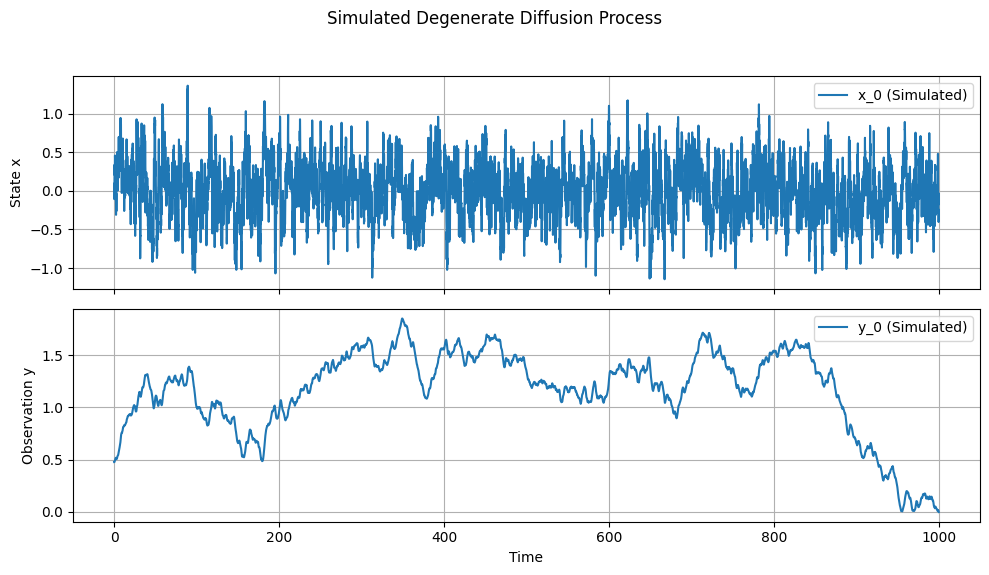

In [2]:
# from einsum_sympy import einsum_sympy # 元のコードにはあったが、このコードでは未使用のためコメントアウトしても良い


@dataclass(frozen=True)
class DegenerateDiffusionProcess:
    """多次元の拡散過程と観測過程を扱うためのクラス。.

    記号計算 (sympy) を用いてモデルを定義し、
    数値計算 (numpy) のための関数を lambdify で生成する。

    Attributes:
        x (sp.Array): 状態変数 (sympyシンボル配列, shape=(d_x,))
        y (sp.Array): 観測変数 (sympyシンボル配列, shape=(d_y,))
        theta_1 (sp.Array): パラメータ1 (sympyシンボル配列)
        theta_2 (sp.Array): パラメータ2 (sympyシンボル配列)
        theta_3 (sp.Array): パラメータ3 (sympyシンボル配列)
        A (sp.Array): ドリフト項の x 成分 (sympy式配列, shape=(d_x,))
        B (sp.Array): 拡散項 (sympy式配列, shape=(d_x, r))
        H (sp.Array): 観測過程のドリフト項 (sympy式配列, shape=(d_y,))
        # --- 以下は __post_init__ で自動生成 ---
        A_func : ドリフト A を計算する numpy 関数
        B_func : 拡散項 B を計算する numpy 関数
        H_func : 観測ドリフト H を計算する numpy 関数

    """

    x: sp.Array
    y: sp.Array
    theta_1: sp.Array
    theta_2: sp.Array
    theta_3: sp.Array
    A: sp.Array
    B: sp.Array
    H: sp.Array

    def __post_init__(self):
        """初期化後の設定処理。
        派生的な属性の計算、lambdifyによる関数生成を行う。
        frozen=True のため、属性設定には object.__setattr__ を使用する。.
        """
        # --- lambdify による数値計算用関数の生成 ---
        common_args = (self.x, self.y)
        try:
            object.__setattr__(
                self, "A_func", lambdify((*common_args, self.theta_2), self.A, modules="numpy")
            )
            object.__setattr__(
                self, "B_func", lambdify((*common_args, self.theta_1), self.B, modules="numpy")
            )
            object.__setattr__(
                self, "H_func", lambdify((*common_args, self.theta_3), self.H, modules="numpy")
            )

        except Exception as e:
            print(f"Error during lambdification in __post_init__: {e}")
            raise

    # --- シミュレーション関数 ---
    def simulate(
        self,
        true_theta: tuple[np.ndarray, np.ndarray, np.ndarray],  # 型ヒント追加
        t_max: float,
        h: float,
        burn_out: float,
        seed: int = 42,
        x0: np.ndarray | None = None,  # 型ヒント追加
        y0: np.ndarray | None = None,  # 型ヒント追加
        dt: float = 0.001,
    ) -> tuple[np.ndarray, np.ndarray]:  # 返り値の型ヒント追加
        """Euler-Maruyama法を用いて状態変数 x と観測変数 y の時系列データを生成する。.

        Parameters
        ----------
            true_theta (tuple): (theta_1_val, theta_2_val, theta_3_val) の真値。
            t_max (float): 生成する時系列データの期間長（burn_out期間を除く）。
            h (float): 生成されるデータの時間ステップ幅（間引き後）。
            burn_out (float): 定常状態に達するまで捨てる初期期間。
            seed (int): 乱数生成器のシード値。
            x0 (np.ndarray, optional): x の初期値ベクトル。None の場合はゼロベクトル。
            y0 (np.ndarray, optional): y の初期値ベクトル。None の場合はゼロベクトル。
            dt (float): シミュレーション内部の微小時間ステップ幅。

        Returns
        -------
            tuple[np.ndarray, np.ndarray]: (x_series, y_series)
                x_series: x の時系列データ (shape=(T, d_x))
                y_series: y の時系列データ (shape=(T, d_y))
                ここで T は t_max / h に近い整数

        """
        np.random.seed(seed)
        theta_1_val, theta_2_val, theta_3_val = true_theta
        total_steps = int(np.round((t_max + burn_out) / dt))  # 丸め処理追加
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        r = self.B.shape[1]  # Number of Wiener processes

        # dt と h の関係チェックと step_stride の計算
        if not np.isclose(h % dt, 0, atol=1e-8) and not np.isclose(h % dt, dt, atol=1e-8):
            print(
                f"Warning: h ({h}) may not be an integer multiple of dt ({dt}). Thinning interval might be slightly inaccurate due to rounding."
            )
        step_stride = max(1, int(np.round(h / dt)))  # 丸めて最低1にする

        x_all = np.zeros((total_steps + 1, d_x))
        y_all = np.zeros((total_steps + 1, d_y))
        x_all[0] = x0 if x0 is not None else np.zeros(d_x)
        y_all[0] = y0 if y0 is not None else np.zeros(d_y)

        for t in range(total_steps):
            xt, yt = x_all[t], y_all[t]
            try:
                # self.*_func を直接呼び出す
                A_val = self.A_func(xt, yt, theta_2_val)
                B_val = self.B_func(xt, yt, theta_1_val)
                H_val = self.H_func(xt, yt, theta_3_val)
            except Exception as e:
                print(f"Error evaluating A, B, or H function at step {t}: {e}")
                print(
                    f"xt={xt}, yt={yt}, theta_1={theta_1_val}, theta_2={theta_2_val}, theta_3={theta_3_val}"
                )
                raise

            dW = np.random.randn(r) * np.sqrt(dt)
            diffusion_term = np.dot(B_val, dW)  # np.dotを使用

            # 形状チェックをタプル (d_x,) と比較
            if diffusion_term.shape != (d_x,):
                msg = f"Shape mismatch in diffusion term: expected ({d_x},), got {diffusion_term.shape}"
                raise ValueError(msg)

            x_all[t + 1] = xt + A_val * dt + diffusion_term
            y_all[t + 1] = yt + H_val * dt
            # もし観測ノイズが必要な場合:
            # 例えば dy = H dt + G dV の G があるなら G_func を __post_init__ で作成
            # G_val = self.G_func(xt, yt, theta_g_val) # Gを計算
            # dV = np.random.randn(d_y) * np.sqrt(dt) # 観測ノイズの増分
            # y_all[t + 1] = yt + H_val * dt + np.dot(G_val, dV)

        # Apply burn-out and thinning
        start_index = int(np.round(burn_out / dt))  # 丸め処理追加

        x_series = x_all[start_index::step_stride]
        y_series = y_all[start_index::step_stride]

        return x_series, y_series


# --- 以下、使用例（元のコードにはなかったので参考として） ---
if __name__ == "__main__":
    # 例: 1次元 Ornstein-Uhlenbeck process (dx = -theta2*x dt + theta1 dW)
    #      観測 y は x に依存しない定数ドリフト (dy = theta3 dt)

    # シンボル定義
    x_sym = sp.Array([symbols("x_0")])
    y_sym = sp.Array([symbols("y_0")])
    theta1_sym = sp.Array([symbols("sigma")])  # diffusion coefficient
    theta2_sym = sp.Array([symbols("kappa")])  # reversion rate
    theta3_sym = sp.Array([symbols("mu")])  # observation drift

    # モデル定義
    A_expr = sp.Array([-theta2_sym[0] * x_sym[0]])
    B_expr = sp.Array([[theta1_sym[0]]])  # shape (d_x, r) = (1, 1)
    H_expr = sp.Array([theta3_sym[0] * x_sym[0]])  # shape (d_y,) = (1,)

    # インスタンス生成
    process = DegenerateDiffusionProcess(
        x=x_sym,
        y=y_sym,
        theta_1=theta1_sym,
        theta_2=theta2_sym,
        theta_3=theta3_sym,
        A=A_expr,
        B=B_expr,
        H=H_expr,
    )

    # パラメータ真値
    true_sigma = np.array([0.5])
    true_kappa = np.array([1.0])
    true_mu = np.array([0.1])
    true_thetas = (true_sigma, true_kappa, true_mu)

    # シミュレーション実行
    T_MAX = 1000.0
    H_STEP = 0.1  # 間引き後のステップ幅
    BURN_OUT = 100.0
    DT_SIM = 0.01  # シミュレーション内部のステップ幅

    print("Simulating...")
    x_data, y_data = process.simulate(
        true_theta=true_thetas,
        t_max=T_MAX,
        h=H_STEP,
        burn_out=BURN_OUT,
        dt=DT_SIM,
        x0=np.array([0.0]),
        y0=np.array([0.0]),
        seed=123,
    )

    print("Simulation finished. Generated data shapes:")
    print(f"x_series shape: {x_data.shape}")  # (T, d_x)
    print(f"y_series shape: {y_data.shape}")  # (T, d_y)

    # 簡単なプロット例 (matplotlibが必要)
    try:
        import matplotlib.pyplot as plt

        time = np.arange(x_data.shape[0]) * H_STEP
        fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        ax[0].plot(time, x_data[:, 0], label="x_0 (Simulated)")
        ax[0].set_ylabel("State x")
        ax[0].grid(True)
        ax[0].legend()
        ax[1].plot(time, y_data[:, 0], label="y_0 (Simulated)")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Observation y")
        ax[1].grid(True)
        ax[1].legend()
        plt.suptitle("Simulated Degenerate Diffusion Process")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # suptitleとの重なり調整
        plt.show()
    except ImportError:
        print("\nMatplotlib not found. Skipping plot.")

In [3]:
# -*- coding: utf-8 -*-
from collections.abc import Callable
from typing import Never

import numpy as np
import sympy as sp
from numpy import einsum, isfinite, nan, power
from sympy import Basic, Expr, S, oo, srepr, symbols, zeros
from sympy.matrices.common import NonInvertibleMatrixError

# --- 定数 ---
INVALID_SREPR_KEY = "invalid_sympy_srepr"


class LikelihoodEvaluator:
    """DegenerateDiffusionProcess モデルに基づき疑似尤度を計算するクラス。
    主要な記号的数式も属性として保持する。.
    """

    def __init__(self, model: "DegenerateDiffusionProcess") -> None:
        """LikelihoodEvaluator のインスタンスを初期化."""
        self.model = model
        self._L_cache: dict[tuple[int, str], Array] = {}
        self._L0_func_cache: dict[tuple[int, str], Callable] = {}
        self._S_func_cache: dict[int, tuple[Callable, ...]] = {}

        # --- モデル属性への参照 ---
        self.x = model.x
        self.y = model.y
        self.theta_1 = model.theta_1
        self.theta_2 = model.theta_2
        self.theta_3 = model.theta_3
        self.A = model.A  # sympy expression
        self.B = model.B  # sympy expression
        self.H = model.H  # sympy expression

        # --- モデルから lambdify 済み関数を取得 ---
        required_funcs = ["A_func", "B_func", "H_func"]
        if not all(
            hasattr(model, func_name) and callable(getattr(model, func_name))
            for func_name in required_funcs
        ):
            missing = [
                f
                for f in required_funcs
                if not hasattr(model, f) or not callable(getattr(model, f))
            ]
            msg = f"Provided model instance is missing required callable functions: {missing}"
            raise AttributeError(msg)
        self.A_func = model.A_func
        self.B_func = model.B_func
        self.H_func = model.H_func

        common_args = (self.x, self.y)

        # --- 派生的な記号計算と lambdify ---
        # 各シンボリックな式も属性として保存する
        try:
            # C = B B^T
            self.C_sym = einsum_sympy("ik,jk->ij", self.B, self.B)
            self.C_func = lambdify((*common_args, self.theta_1), self.C_sym, modules="numpy")

            C_matrix = Matrix(self.C_sym)
            self.inv_C_expr = None
            self.log_det_C_expr = None
            try:
                self.inv_C_expr = Array(C_matrix.inv())
                self.inv_C_func = lambdify(
                    (*common_args, self.theta_1), self.inv_C_expr, modules="numpy"
                )
            except NonInvertibleMatrixError:
                print(
                    "Warning: Symbolic matrix C is not invertible. inv_C_expr and inv_C_func set to None."
                )
                self.inv_C_func = None  # inv_C_expr は既に None で初期化済み
            except Exception as e:
                print(
                    f"Warning: Error inverting C matrix or lambdifying: {e}. inv_C_expr and inv_C_func set to None."
                )
                self.inv_C_func = None

            try:
                det_C_val = C_matrix.det()
                if det_C_val.is_nonpositive:
                    print(
                        "Warning: Symbolic det(C) is non-positive. log_det_C_expr and log_det_C_func set to None."
                    )
                    self.log_det_C_func = None
                elif det_C_val == 0:
                    print(
                        "Warning: Symbolic det(C) is zero. log_det_C_expr set to -oo (func to None)."
                    )
                    self.log_det_C_expr = -oo
                    self.log_det_C_func = None
                else:
                    self.log_det_C_expr = log(det_C_val)
                    self.log_det_C_func = lambdify(
                        (*common_args, self.theta_1), self.log_det_C_expr, modules="numpy"
                    )
            except Exception as e:
                print(
                    f"Warning: Could not reliably determine sign of det(C) or log failed ({e}). log_det_C_expr and log_det_C_func set to None."
                )
                self.log_det_C_func = None

            # dH/dx
            self.partial_x_H_sym = derive_by_array(self.H, self.x)
            # self.partial_x_H_func は必要に応じて作成 (V3などで使用)
            # self.partial_x_H_func = lambdify((*common_args, self.theta_3), self.partial_x_H_sym, modules="numpy")

            # V = (dH/dx) C (dH/dx)^T
            self.V_sym = einsum_sympy(
                "ki,kl,lj->ij", self.partial_x_H_sym, self.C_sym, self.partial_x_H_sym
            )
            self.V_func = lambdify(
                (*common_args, self.theta_1, self.theta_3), self.V_sym, modules="numpy"
            )

            V_matrix = Matrix(self.V_sym)
            self.inv_V_expr = None
            self.log_det_V_expr = None
            try:
                self.inv_V_expr = Array(V_matrix.inv())
                self.inv_V_func = lambdify(
                    (*common_args, self.theta_1, self.theta_3), self.inv_V_expr, modules="numpy"
                )
            except NonInvertibleMatrixError:
                print(
                    "Warning: Symbolic matrix V is not invertible. inv_V_expr and inv_V_func set to None."
                )
                self.inv_V_func = None
            except Exception as e:
                print(
                    f"Warning: Error inverting V matrix or lambdifying: {e}. inv_V_expr and inv_V_func set to None."
                )
                self.inv_V_func = None

            try:
                det_V_val = V_matrix.det()
                # det <= 0 の場合 log で ValueError が発生するのを避ける (lambdify 時も考慮)
                if det_V_val.is_nonpositive:  # Sympy の is_nonpositive で判定
                    print(
                        "Warning: Symbolic det(V) is non-positive. log_det_V_expr and log_det_V_func set to None."
                    )
                    self.log_det_V_func = None
                elif det_V_val == 0:
                    print(
                        "Warning: Symbolic det(V) is zero. log_det_V_expr set to -oo (func to None)."
                    )
                    self.log_det_V_expr = -oo
                    self.log_det_V_func = None
                else:
                    self.log_det_V_expr = log(det_V_val)
                    self.log_det_V_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.log_det_V_expr,
                        modules="numpy",
                    )
            except Exception as e:  # is_nonpositive が判定不能な場合など
                print(
                    f"Warning: Could not reliably determine sign of det(V) or log failed ({e}). log_det_V_expr and log_det_V_func set to None."
                )
                self.log_det_V_func = None

            # (dH/dx)^T inv(V)
            self.partial_x_H_transpose_inv_V_expr = None
            if self.inv_V_expr is not None:  # inv_V_expr が計算できた場合のみ
                try:
                    # partial_x_H_sym は (d_y, d_x), inv_V_expr は (d_y, d_y)
                    # 結果は (d_x, d_y) になるように転置と積の順番を調整
                    # (dH/dx)^T は (d_x, d_y)
                    # (dH/dx)^T @ inv(V) は (d_x, d_y) @ (d_y, d_y) -> (d_x, d_y)
                    self.partial_x_H_transpose_inv_V_expr = einsum_sympy(
                        "ji,jk->ik", self.partial_x_H_sym, self.inv_V_expr
                    )
                    self.partial_x_H_transpose_inv_V_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.partial_x_H_transpose_inv_V_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating partial_x_H_transpose_inv_V_expr or func: {e}")
                    self.partial_x_H_transpose_inv_V_func = None
            else:
                self.partial_x_H_transpose_inv_V_func = None

            # S0 関連のシンボリックな式を初期化
            self.inv_S0_xx_expr = None
            self.inv_S0_xy_expr = None
            self.inv_S0_yx_expr = None
            self.inv_S0_yy_expr = None
            self.log_det_S0_expr = None

            # inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yyを計算する
            if (
                self.inv_C_expr is not None
                and self.inv_V_expr is not None
                and self.partial_x_H_transpose_inv_V_expr is not None
            ):
                try:
                    # S_0^{-1}_xx = C^{-1} + 3 (dH/dx)^T V^{-1} (dH/dx)
                    # partial_x_H_transpose_inv_V_expr (ik) is (d_x, d_y)
                    # self.partial_x_H_sym (lj) is (d_y, d_x)
                    # einsum('ik,lj->il', (dH/dx)^T V^{-1} , dH/dx) where k=l
                    # -> einsum('ik,kj->ij', (dH/dx)^T V^{-1} , dH/dx)
                    term_for_invS0xx = einsum_sympy(
                        "ik,kj->ij", self.partial_x_H_transpose_inv_V_expr, self.partial_x_H_sym
                    )
                    self.inv_S0_xx_expr = self.inv_C_expr + 3 * term_for_invS0xx
                    self.inv_S0_xx_func = lambdify(
                        (
                            *common_args,
                            self.theta_1,
                            self.theta_3,
                        ),  # theta_1 for C, theta_1, theta_3 for V and dHdx
                        self.inv_S0_xx_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xx_expr or func: {e}")
                    self.inv_S0_xx_func = None

                try:
                    # S_0^{-1}_xy = -6 (dH/dx)^T V^{-1}
                    self.inv_S0_xy_expr = -6 * self.partial_x_H_transpose_inv_V_expr
                    self.inv_S0_xy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_xy_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_xy_expr or func: {e}")
                    self.inv_S0_xy_func = None

                try:
                    # S_0^{-1}_yx = -6 V^{-1} (dH/dx)
                    # inv_V_expr (ik) is (d_y, d_y)
                    # self.partial_x_H_sym (kj) is (d_y, d_x)
                    # einsum('ik,kj->ij', inv_V_expr, self.partial_x_H_sym) -> (d_y, d_x)
                    self.inv_S0_yx_expr = -6 * einsum_sympy(
                        "ik,kj->ij", self.inv_V_expr, self.partial_x_H_sym
                    )
                    # または self.inv_S0_yx_expr = Array(sp.transpose(Matrix(self.inv_S0_xy_expr))) でも可のはず
                    self.inv_S0_yx_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_yx_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yx_expr or func: {e}")
                    self.inv_S0_yx_func = None

                try:
                    # S_0^{-1}_yy = 12 V^{-1}
                    self.inv_S0_yy_expr = 12 * self.inv_V_expr
                    self.inv_S0_yy_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.inv_S0_yy_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating inv_S0_yy_expr or func: {e}")
                    self.inv_S0_yy_func = None
            else:
                print(
                    "Warning: Could not create inv_S0_xx, inv_S0_xy, inv_S0_yx, inv_S0_yy expressions/functions due to previous errors with C_inv, V_inv or dHdx_T_V_inv."
                )
                self.inv_S0_xx_func = None
                self.inv_S0_xy_func = None
                self.inv_S0_yx_func = None
                self.inv_S0_yy_func = None

            # log_det_S0の計算
            if (
                self.log_det_C_expr is not None
                and self.log_det_V_expr is not None
                and self.log_det_C_expr != -oo
                and self.log_det_V_expr != -oo
            ):
                try:
                    self.y.shape[0]
                    # log(det(S0)) = log(det(C)) + log(det(V)) + d_y * log(1/12)
                    # log(1/12) = -log(12)
                    self.log_det_S0_expr = self.log_det_C_expr + self.log_det_V_expr
                    self.log_det_S0_func = lambdify(
                        (*common_args, self.theta_1, self.theta_3),
                        self.log_det_S0_expr,
                        modules="numpy",
                    )
                except Exception as e:
                    print(f"Error creating log_det_S0_expr or func: {e}")
                    self.log_det_S0_func = None
            else:
                print(
                    "Warning: Could not create log_det_S0_expr or func due to issues with log_det_C or log_det_V."
                )
                if self.log_det_C_expr == -oo or self.log_det_V_expr == -oo:
                    self.log_det_S0_expr = -oo  # detが0ならlog(det)は-oo
                self.log_det_S0_func = None

        except Exception as e:
            print(
                f"CRITICAL Error during symbolic calc/lambdify in LikelihoodEvaluator __init__: {e}"
            )
            # ここで None に設定されていない可能性のある関数も None にしておく
            self.C_func = None
            self.inv_C_func = None
            self.log_det_C_func = None
            self.V_func = None
            self.inv_V_func = None
            self.log_det_V_func = None
            self.partial_x_H_transpose_inv_V_func = None
            self.inv_S0_xx_func = None
            self.inv_S0_xy_func = None
            self.inv_S0_yx_func = None
            self.inv_S0_yy_func = None
            self.log_det_S0_func = None
            raise

    # --- キャッシュキーヘルパー (変更なし) ---
    def _get_tensor_srepr(self, tensor: Basic) -> str:
        try:
            if isinstance(tensor, Array):
                return srepr(tensor.tolist())
            return srepr(tensor)
        except Exception as e:
            print(f"Warning: srepr failed for {type(tensor)}. Using fallback. Error: {e}")
            return INVALID_SREPR_KEY

    # --- Infinitesimal Generator L (変更なし) ---
    def _L_elem_once(self, f_elem: Basic) -> Basic:
        if not isinstance(f_elem, Expr) or f_elem.is_constant(simplify=False):
            return S(0)
        try:
            f_elem_sym = sp.sympify(f_elem)
            df_dx = derive_by_array(f_elem_sym, self.x)
            df_dy = derive_by_array(f_elem_sym, self.y)
            d2f_dx2 = derive_by_array(df_dx, self.x)

            # self.C_sym は __init__ で計算済みのシンボリックな C
            C_term_sym = self.C_sym

            term1 = einsum_sympy("i,i->", self.A, df_dx)
            term2 = einsum_sympy("i,i->", self.H, df_dy)
            term3 = (S(1) / 2) * einsum_sympy("ij,ij->", C_term_sym, d2f_dx2)
            return term1 + term2 + term3
        except Exception:
            print(
                f"Error applying _L_elem_once to: {type(f_elem)} with srepr: {self._get_tensor_srepr(f_elem)}"
            )
            raise

    def L(self, f_tensor: Basic, k: int) -> Basic:
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L_cache:
            return self._L_cache[cache_key]

        if k == 0:
            result = f_tensor
        elif k < 0:
            msg = "Order k must be non-negative"
            raise ValueError(msg)
        else:
            f_prev = self.L(f_tensor, k - 1)
            try:
                if isinstance(f_prev, Array) and hasattr(f_prev, "applyfunc"):
                    result = f_prev.applyfunc(self._L_elem_once)
                elif isinstance(f_prev, (Expr, Basic)):
                    result = self._L_elem_once(f_prev)
                else:
                    print(f"Warning: Applying L to non-symbolic {type(f_prev)} in L(k={k}).")
                    result = zeros(*f_prev.shape) if hasattr(f_prev, "shape") else S(0)
            except Exception:
                print(f"Error in L applying L once for k={k}")
                print(f"L^{k - 1}(f): {type(f_prev)}, srepr: {self._get_tensor_srepr(f_prev)}")
                raise
        self._L_cache[cache_key] = result
        return result

    def L_0(self, f_tensor: Basic, k: int) -> Basic:
        if k < 0:
            msg = "k must be non-negative"
            raise ValueError(msg)
        Lk_f = self.L(f_tensor, k)
        fact_k = factorial(k)
        if fact_k == 0:  # Should only happen if k is not a non-negative integer, but factorial(0)=1
            msg = f"Factorial({k}) is zero? This should not happen."
            raise ValueError(msg)

        try:
            if isinstance(Lk_f, Array) and hasattr(Lk_f, "applyfunc"):
                # Make sure division by sympy.Integer works for Array elements
                result = Lk_f.applyfunc(lambda elem: elem / S(fact_k))
            elif isinstance(Lk_f, (Expr, Basic)):
                result = Lk_f / S(fact_k)  # Use S(fact_k) for symbolic division
            else:  # e.g. numpy array if something went wrong or for testing
                result = Lk_f / float(fact_k)
        except Exception:
            print(f"Error in L_0 dividing by factorial({k})")
            print(f"Lk_f type: {type(Lk_f)}, srepr: {self._get_tensor_srepr(Lk_f)}")
            raise
        return result

    def L_0_func(self, f_tensor: Basic, k: int) -> Callable:
        cache_key = (k, self._get_tensor_srepr(f_tensor))
        if cache_key in self._L0_func_cache:
            return self._L0_func_cache[cache_key]
        try:
            L0_expr_val = self.L_0(f_tensor, k)
            # lambdifyの引数に self.model のシンボルを渡す
            lambdify_args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)

            # Check if L0_expr_val contains any free symbols not in lambdify_args
            # free_symbols_in_expr = L0_expr_val.free_symbols if hasattr(L0_expr_val, 'free_symbols') else set()
            # if isinstance(L0_expr_val, Array):
            #     free_symbols_in_expr = set()
            #     for elem in L0_expr_val:
            #         free_symbols_in_expr.update(elem.free_symbols if hasattr(elem, 'free_symbols') else set())

            # arg_symbols = set(s for arr in [self.x, self.y, self.theta_1, self.theta_2, self.theta_3] for s in arr)
            # if not free_symbols_in_expr.issubset(arg_symbols):
            #     print(f"Warning: L0_expr for k={k}, srepr={cache_key[1]} contains free symbols not in lambdify args: {free_symbols_in_expr - arg_symbols}")

            func = lambdify(lambdify_args, L0_expr_val, modules="numpy")
            self._L0_func_cache[cache_key] = func
            return func
        except Exception:
            print(f"Error creating L_0_func for k={k}, srepr={cache_key[1]}")
            print(f"Expression was: {L0_expr_val if 'L0_expr_val' in locals() else 'undefined'}")
            raise

    # --- Auxiliary functions for Quasi-Likelihood ---
    def Dx_func(
        self,
        L0_x_funcs: dict[int, Callable],
        x_j: np.ndarray,
        x_j_1: np.ndarray,
        y_j_1: np.ndarray,
        # theta_2_val_for_A: np.ndarray, # A(theta_2) を評価するパラメータ
        theta_2_val: np.ndarray,  # A(theta_2) を評価するパラメータ
        theta_1_bar: np.ndarray,
        theta_2_bar: np.ndarray,
        theta_3_bar: np.ndarray,  # L0(bar) 用
        h: float,
        k_arg: int,
    ) -> np.ndarray:  # k_arg は数式 D^k の k に対応
        if h <= 0:
            return np.zeros_like(x_j)
        DX_SCALE = power(h, -0.5)

        D_x = DX_SCALE * (x_j - x_j_1)  # Base term for k_arg = 0

        if k_arg >= 1:  # A term is present if k_arg is 1 or more
            try:
                # V1 の場合、D^{k-1}(bar_theta) を使うので A は theta_2_bar で評価
                A_val = self.A_func(x_j_1, y_j_1, theta_2_val)
            except Exception as e:
                msg = f"Dx_func: A_func eval error: {e}"
                raise RuntimeError(msg) from e
            D_x -= DX_SCALE * power(h, 1) * A_val

        if k_arg >= 2:  # Summation term is present if k_arg is 2 or more
            args_for_L0_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
            for m_loop in range(2, k_arg + 1):  # Sum from m=2 to k_arg
                h_pow_m = power(h, m_loop)
                try:
                    L0_x_m_val = L0_x_funcs[m_loop](*args_for_L0_bar)
                except KeyError as e:
                    msg = f"Dx_func: L0_x_funcs key m={m_loop} not found (dict has keys for m up to {max(L0_x_funcs.keys()) if L0_x_funcs else 'empty'}). k_arg was {k_arg}."
                    raise RuntimeError(msg) from e
                except Exception as e:
                    msg = f"Dx_func: L0_x_funcs[{m_loop}] eval error: {e}"
                    raise RuntimeError(msg) from e
                D_x -= DX_SCALE * h_pow_m * L0_x_m_val
        return D_x

    def Dy_func(
        self,
        L0_y_funcs: dict[int, Callable],
        y_j: np.ndarray,
        y_j_1: np.ndarray,
        x_j_1: np.ndarray,
        theta_3_val: np.ndarray,  # H(theta_3) を評価するパラメータ
        theta_1_bar: np.ndarray,
        theta_2_bar: np.ndarray,
        theta_3_bar: np.ndarray,  # L0(bar) 用
        h: float,
        k_arg: int,
    ) -> np.ndarray:  # k_arg は数式 D^k の k に対応
        if h <= 0:
            return np.zeros_like(y_j)
        DY_SCALE = power(h, -1.5)

        D_y = DY_SCALE * (y_j - y_j_1)  # Base term for k_arg = 0

        if k_arg >= 1:  # H term is present if k_arg is 1 or more
            try:
                # V1 の場合、D^{k-1}(bar_theta) を使うので H は theta_3_bar で評価
                H_val = self.H_func(x_j_1, y_j_1, theta_3_val)
            except Exception as e:
                msg = f"Dy_func: H_func eval error: {e}"
                raise RuntimeError(msg) from e
            D_y -= DY_SCALE * power(h, 1) * H_val

        if k_arg >= 2:  # Summation term is present if k_arg is 2 or more
            args_for_L0_bar = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
            # For D^k_y, the sum is from m=2 to k+1
            for m_loop in range(2, k_arg + 2):  # Sum from m=2 to k_arg+1
                h_pow_m = power(h, m_loop)
                try:
                    L0_y_m_val = L0_y_funcs[m_loop](*args_for_L0_bar)
                except KeyError as e:
                    msg = f"Dy_func: L0_y_funcs key m={m_loop} not found (dict has keys for m up to {max(L0_y_funcs.keys()) if L0_y_funcs else 'empty'}). k_arg was {k_arg}."
                    raise RuntimeError(msg) from e
                except Exception as e:
                    msg = f"Dy_func: L0_y_funcs[{m_loop}] eval error: {e}"
                    raise RuntimeError(msg) from e
                D_y -= DY_SCALE * h_pow_m * L0_y_m_val
        return D_y

    # --- S 項の計算 (変更なし) ---
    def S(self, k: int) -> tuple[Array, Array, Array, Array]:
        x_sym = self.x
        y_sym = self.y

        # T terms: E[X_i X_j], E[X_i Y_j] etc. at higher orders
        # T_xx = L_0( tensor(x,x), k+1) means ( L^(k+1) (x tensor x) ) / (k+1)!
        T_xx = self.L_0(tensorproduct(x_sym, x_sym), k + 1)
        T_xy = self.L_0(tensorproduct(x_sym, y_sym), k + 2)
        T_yx = self.L_0(tensorproduct(y_sym, x_sym), k + 2)
        T_yy = self.L_0(tensorproduct(y_sym, y_sym), k + 3)

        def compute_U_component(f1: Array, f2: Array, total_sum_order: int) -> Array:
            if not (isinstance(f1, Array) and f1.rank() == 1):
                msg = f"U computation requires rank-1 Array for f1, got {type(f1)}"
                raise ValueError(msg)
            if not (isinstance(f2, Array) and f2.rank() == 1):
                msg = f"U computation requires rank-1 Array for f2, got {type(f2)}"
                raise ValueError(msg)

            # Initialize U_component as a symbolic zero array of the correct shape
            # This ensures symbolic addition works correctly.
            # Assuming f1 and f2 are 1D arrays (vectors)
            u_shape = (f1.shape[0], f2.shape[0])
            U_component = Array(zeros(*u_shape))

            for m1 in range(total_sum_order + 1):
                m2 = total_sum_order - m1
                try:
                    L0_f1_m1 = self.L_0(f1, m1)  # L^m1(f1)/m1!
                    L0_f2_m2 = self.L_0(f2, m2)  # L^m2(f2)/m2!

                    # tensorproduct should handle Array inputs correctly
                    term = tensorproduct(L0_f1_m1, L0_f2_m2)

                    if term.shape != u_shape:
                        # Attempt to reshape if the number of elements is the same
                        if np.prod(term.shape) == np.prod(u_shape):
                            print(
                                f"Warning: compute_U_component term shape mismatch ({term.shape} vs {u_shape}). Reshaping."
                            )
                            term = Array(term).reshape(*u_shape)
                        else:
                            msg = f"compute_U_component term shape mismatch ({term.shape} vs {u_shape}) and cannot reshape."
                            raise ValueError(msg)

                    U_component = U_component + term
                except Exception as e:
                    msg = (
                        f"Error in compute_U_component for f1={f1}, f2={f2}, m1={m1}, m2={m2}: {e}"
                    )
                    raise RuntimeError(msg) from e
            return Array(U_component)  # Ensure it's an Array

        # U terms: Sum_{m1+m2=total_order} (L^m1(f1)/m1!) tensor (L^m2(f2)/m2!)
        U_xx = compute_U_component(x_sym, x_sym, k + 1)
        U_xy = compute_U_component(x_sym, y_sym, k + 2)
        U_yx = compute_U_component(y_sym, x_sym, k + 2)
        U_yy = compute_U_component(y_sym, y_sym, k + 3)

        try:
            # Ensure T and U are compatible for subtraction (both are Sympy Arrays)
            S_xx = Array(T_xx) - Array(U_xx)
            S_xy = Array(T_xy) - Array(U_xy)
            S_yx = Array(T_yx) - Array(U_yx)
            S_yy = Array(T_yy) - Array(U_yy)
        except Exception as e:
            msg = f"Error subtracting U from T for S(k={k}): {e}. Types: T_xx={type(T_xx)}, U_xx={type(U_xx)}"
            raise RuntimeError(msg) from e

        return S_xx, S_xy, S_yx, S_yy

    def S_func(self, k: int) -> tuple[Callable, Callable, Callable, Callable]:
        cache_key = k
        if cache_key in self._S_func_cache:
            return self._S_func_cache[cache_key]
        try:
            S_k = self.S(k)
            S_xx_expr = S_k[0]
            S_xy_expr = S_k[1]
            S_yx_expr = S_k[2]
            S_yy_expr = S_k[3]
            lambdify_args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)
            f_xx = lambdify(lambdify_args, S_xx_expr, modules="numpy")
            f_xy = lambdify(lambdify_args, S_xy_expr, modules="numpy")
            f_yx = lambdify(lambdify_args, S_yx_expr, modules="numpy")
            f_yy = lambdify(lambdify_args, S_yy_expr, modules="numpy")

            funcs = (f_xx, f_xy, f_yx, f_yy)
            self._S_func_cache[cache_key] = funcs
            return funcs
        except Exception as e:
            print(f"Error creating S_func for k={k}: {e}")
            raise

    # --- Quasi-Likelihood Evaluator Factories (変更なし) ---
    # make_quasi_likelihood_v1_prime_evaluator,
    # make_quasi_likelihood_v1_evaluator,
    # make_quasi_likelihood_v2_evaluator,
    # make_quasi_likelihood_v3_evaluator
    # の実装は前回のコードと同じなので省略します。
    # EVALUATOR_FACTORIES_START
    def make_quasi_likelihood_v1_prime_evaluator(
        self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int
    ) -> Callable:
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            msg = "Time series length must be > 1 and shapes must match for V1'."
            raise ValueError(msg)

        try:
            # Dx の展開次数は k-1 まで。L0_x_funcs のキーは 0 から k-1 まで。
            # Dx_funcの引数kは L0の最高次数+1 なので、Dx_func(..., k_dx) のとき L0_x_funcs は k_dx 次まで必要。
            # V1'の論文ではDxの展開次数はk-1なので L0_x_funcsは range(k) => {0, ..., k-1}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}  # m = 0, ..., k-1
            # S_l の展開次数は k-1 まで。S_func の引数は l で、l=1,...,k-1
            S_l_funcs = {l_s: self.S_func(l_s) for l_s in range(1, k)}  # l_s = 1, ..., k-1
        except Exception as e:
            msg = f"V1' precalculation error: {e}"
            raise RuntimeError(msg) from e

        if self.inv_C_func is None or self.log_det_C_func is None:
            msg = "inv_C_func or log_det_C_func is missing for V1'. Check __init__ warnings."
            raise RuntimeError(msg)

        def evaluate_v1_prime(
            theta_1_val: np.ndarray,
            theta_1_bar: np.ndarray,
            theta_2_bar: np.ndarray,
            theta_3_bar: np.ndarray,
        ) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                # y_j = y_series[j_idx] # Not directly used in V1' formula terms
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_val)  # Depends on theta_1_val
                    logDetC_val = self.log_det_C_func(
                        x_j_1, y_j_1, theta_1_val
                    )  # Depends on theta_1_val
                except Exception as e:
                    print(f"Error during inv_C or log_det_C evaluation at step j={j_idx}: {e}")
                try:
                    # Dx_func の k は L0 の最高次数。V1'では k-1 次まで展開。
                    # L0_x_funcs は 0 から k-1 までの関数を持つ。
                    # Dx_func に渡す k は、L0_x_funcs の最大の m と同じにする。
                    # つまり、Dx(k-1) を計算するなら、L0_x_funcs は range(k-1+1) = range(k) => {0,...,k-1}
                    Dx_k_param = k - 1
                    Dx_val = self.Dx_func(
                        L0_x_funcs,
                        x_j,
                        x_j_1,
                        y_j_1,
                        theta_2_bar,  # A(theta_2_bar)
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar)
                        h,
                        Dx_k_param,
                    )
                except Exception as e:
                    print(f"Error during Dx_func evaluation at step j={j_idx}: {e}")
                try:
                    sum_Sxx_val = np.zeros((d_x, d_x), dtype=float)
                    for l_s_loop in range(1, k):  # l_s = 1 to k-1
                        Sxx_func_l = S_l_funcs[l_s_loop][0]  # S_xx for S_l
                        Sxx_l_val = Sxx_func_l(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        sum_Sxx_val += power(h, l_s_loop) * Sxx_l_val
                except Exception as e:
                    print(f"Error during Sxx_func evaluation at step j={j_idx}: {e}")
                try:
                    # V1' Likelihood terms
                    # Term1: - Dx^T inv(C) Dx
                    term1_quad = -einsum("ij,i,j", invC_val, Dx_val, Dx_val)
                    # Term2: Tr(inv(C) * sum(h^l S_xx^(l)))
                    term2_trace = +einsum(
                        "ij,ji", invC_val, sum_Sxx_val
                    )  # sumSxx_val is already h^l * S_xx
                    # Term3: -log(det(C))
                    term3_logdet = -logDetC_val

                    step_likelihood = term1_quad + term2_trace + term3_logdet
                    if not isfinite(step_likelihood):
                        print(f"Warning: V1' eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(
                            f"  T1_quad={term1_quad}, T2_trace={term2_trace}, T3_logdet={term3_logdet}"
                        )
                        print(
                            f"  invC={invC_val}, Dx={Dx_val}, sumSxx={sum_Sxx_val}, logDetC={logDetC_val}"
                        )
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V1' evaluation at step j={j_idx}: {e}")
                    print(
                        f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th1_val={theta_1_val}, th_bars=..."
                    )
                    return nan
            # Factor 1/2 is typical for log-likelihood of Gaussian
            return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan

        return evaluate_v1_prime

    def make_quasi_likelihood_v1_evaluator(
        self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int
    ) -> Callable:
        n = x_series.shape[0]
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            msg = "Time series length must be > 1 and shapes must match for V1."
            raise ValueError(msg)

        try:
            # Dx の展開次数は k-1。 L0_x_funcs は range(k) => {0,...,k-1}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}
            # Dy の展開次数は k。   L0_y_funcs は range(k+1) => {0,...,k}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 1)}
            # S_l の展開次数は k-1。 S_l_funcs は l=1,...,k-1
            S_l_funcs = {l_s: self.S_func(l_s) for l_s in range(1, k)}
        except Exception as e:
            msg = f"V1 precalculation error: {e}"
            raise RuntimeError(msg) from e

        # Check if S0 related functions were successfully created
        s0_funcs_needed = [
            self.inv_S0_xx_func,
            self.inv_S0_xy_func,
            self.inv_S0_yx_func,
            self.inv_S0_yy_func,
            self.log_det_S0_func,
        ]
        if any(f is None for f in s0_funcs_needed):
            missing_s0_func_names = [
                name
                for name, func in zip(
                    [
                        "inv_S0_xx_func",
                        "inv_S0_xy_func",
                        "inv_S0_yx_func",
                        "inv_S0_yy_func",
                        "log_det_S0_func",
                    ],
                    s0_funcs_needed,
                    strict=False,
                )
                if func is None
            ]
            msg = f"S0 related functions {missing_s0_func_names} are missing for V1. Check __init__ warnings."
            raise RuntimeError(msg)

        def evaluate_v1(
            theta_1_val: np.ndarray,
            theta_1_bar: np.ndarray,
            theta_2_bar: np.ndarray,
            theta_3_bar: np.ndarray,
        ) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                y_j = y_series[j_idx]
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # inv_S0 functions depend on theta_1_val (for C part) and theta_3_bar (for V part)
                    inv_S0_xx_val = self.inv_S0_xx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_xy_val = self.inv_S0_xy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_yx_val = self.inv_S0_yx_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)
                    inv_S0_yy_val = self.inv_S0_yy_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)

                    # log_det_S0 depends on theta_1_val and theta_3_bar
                    log_det_S0_val = self.log_det_S0_func(x_j_1, y_j_1, theta_1_val, theta_3_bar)

                    # Dx(k-1) and Dy(k)
                    Dx_k_param = k - 1  # For Dx, up to L0_x_funcs[k-1]
                    Dy_k_param = k - 1  # For Dy, up to L0_y_funcs[k]

                    Dx_val = self.Dx_func(
                        L0_x_funcs,
                        x_j,
                        x_j_1,
                        y_j_1,
                        theta_2_bar,  # A(theta_2_bar)
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar)
                        h,
                        Dx_k_param,
                    )
                    Dy_val = self.Dy_func(
                        L0_y_funcs,
                        y_j,
                        y_j_1,
                        x_j_1,
                        theta_3_bar,  # H(theta_3_bar)
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar)
                        h,
                        Dy_k_param,
                    )

                    # Sum of S terms (S_xx, S_xy, S_yx, S_yy)
                    # These are S^(l) for l=1 to k-1
                    sum_S_xx = np.zeros((d_x, d_x), dtype=float)
                    sum_S_xy = np.zeros((d_x, d_y), dtype=float)
                    sum_S_yx = np.zeros((d_y, d_x), dtype=float)
                    sum_S_yy = np.zeros((d_y, d_y), dtype=float)

                    for l_s_loop in range(1, k):  # l_s = 1 to k-1
                        s_funcs_l = S_l_funcs[l_s_loop]
                        s_xx_l = s_funcs_l[0](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_xy_l = s_funcs_l[1](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_yx_l = s_funcs_l[2](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                        s_yy_l = s_funcs_l[3](x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)

                        h_pow_l = power(h, l_s_loop)
                        # sum_S_xx += h^l * S_xx^(l)
                        # sum_S_xy += h^l * S_xy^(l)
                        # sum_S_yx += h^l * S_yx^(l)
                        # sum_S_yy += h^l * S_yy^(l)
                        sum_S_xx += h_pow_l * s_xx_l
                        sum_S_xy += h_pow_l * s_xy_l
                        sum_S_yx += h_pow_l * s_yx_l
                        sum_S_yy += h_pow_l * s_yy_l

                    # Quadratic terms: - D^T inv(S0) D
                    # - Dx^T invS0_xx Dx - Dx^T invS0_xy Dy - Dy^T invS0_yx Dx - Dy^T invS0_yy Dy
                    q_xx = einsum("ij,i,j", inv_S0_xx_val, Dx_val, Dx_val)
                    q_xy = einsum("ij,i,j", inv_S0_xy_val, Dx_val, Dy_val)
                    q_yx = einsum("ij,i,j", inv_S0_yx_val, Dy_val, Dx_val)  # Note order of Dy, Dx
                    q_yy = einsum("ij,i,j", inv_S0_yy_val, Dy_val, Dy_val)
                    quadratic_term = -(q_xx + q_xy + q_yx + q_yy)
                    # Trace terms: Tr(inv(S0) * Sum_S)
                    # Tr(invS0_xx SumS_xx) + Tr(invS0_xy SumS_yx) + Tr(invS0_yx SumS_xy) + Tr(invS0_yy SumS_yy)
                    # Note: Sxy is (dx,dy), Syx is (dy,dx)
                    tr_xx = einsum(
                        "ij,ji", inv_S0_xx_val, sum_S_xx
                    )  # sum_S_xx is already h^l * S_xx
                    tr_xy = einsum(
                        "ij,ji", inv_S0_xy_val, sum_S_yx
                    )  # invS0_xy(dx,dy), sum_S_yx(dy,dx)
                    tr_yx = einsum(
                        "ij,ji", inv_S0_yx_val, sum_S_xy
                    )  # invS0_yx(dy,dx), sum_S_xy(dx,dy)
                    tr_yy = einsum("ij,ji", inv_S0_yy_val, sum_S_yy)
                    trace_term = tr_xx + tr_xy + tr_yx + tr_yy

                    logdet_term = -log_det_S0_val

                    step_likelihood = quadratic_term + trace_term + logdet_term
                    if not isfinite(step_likelihood):
                        print(f"Warning: V1 eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(f"  Quad={quadratic_term} (xx:{q_xx} xy:{q_xy} yx:{q_yx} yy:{q_yy})")
                        print(f"  Trace={trace_term} (xx:{tr_xx} xy:{tr_xy} yx:{tr_yx} yy:{tr_yy})")
                        print(f"  LogDet={logdet_term}")
                        print(f"  Dx={Dx_val}, Dy={Dy_val}")
                        # print(f"  invS0_xx={inv_S0_xx_val}, invS0_xy={inv_S0_xy_val}, invS0_yx={inv_S0_yx_val}, invS0_yy={inv_S0_yy_val}")
                        # print(f"  sumS_xx={sum_S_xx}, sumS_xy={sum_S_xy}, sumS_yx={sum_S_yx}, sumS_yy={sum_S_yy}")
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V1 evaluation at step j={j_idx}: {e}")
                    print(
                        f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th1_val={theta_1_val}, th_bars=..."
                    )
                    return nan
            return total_log_likelihood / (2.0 * num_transitions) if num_transitions > 0 else nan

        return evaluate_v1

    def make_quasi_likelihood_v2_evaluator(
        self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int
    ) -> Callable:
        n = x_series.shape[0]
        # d_x = self.x.shape[0] # Not directly used here but good for consistency
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            msg = "Time series length must be > 1 and shapes must match for V2."
            raise ValueError(msg)

        try:
            # Dx の展開次数は k。 L0_x_funcs は range(k+1) => {0,...,k}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 1)}
        except Exception as e:
            msg = f"V2 precalculation error (L0_x): {e}"
            raise RuntimeError(msg) from e

        if self.inv_C_func is None:  # V2 uses inv_C but not log_det_C
            msg = "inv_C_func is missing for V2. Check __init__ warnings."
            raise RuntimeError(msg)

        def evaluate_v2(
            theta_2_val: np.ndarray,  # theta_2 to be optimized
            theta_1_bar: np.ndarray,
            theta_2_bar: np.ndarray,  # Used for L0 terms if k > 0
            theta_3_bar: np.ndarray,
        ) -> float:
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                # y_j = y_series[j_idx] # Not used
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # invC depends on theta_1_bar
                    invC_val = self.inv_C_func(x_j_1, y_j_1, theta_1_bar)

                    # Dx_func の k は L0 の最高次数。V2では k 次まで展開。
                    # L0_x_funcs は 0 から k までの関数を持つ。
                    Dx_k_param = k
                    Dx_val = self.Dx_func(
                        L0_x_funcs,
                        x_j,
                        x_j_1,
                        y_j_1,
                        theta_2_val,  # A(theta_2_val) <--- Uses theta_2_val
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar for m>1)
                        h,
                        Dx_k_param,
                    )

                    # V2 Likelihood term: - Dx^T inv(C) Dx (scaled differently from V1')
                    # The original V2 definition might be sum_j (Dx_j)^T C_j^{-1} (Dx_j) / (2h)
                    # or similar, check the source for exact scaling.
                    # Here, we're calculating sum ( - Dx^T invC Dx ) and then scaling.
                    # If Dx_func returns h^{-0.5} * (delta_x - sum h^m L0_x_m),
                    # then (Dx_val)^T invC (Dx_val) is already scaled by 1/h.
                    # So, term1 is sum_j [ h^{-1} * (discrete_part - continuous_part)^T invC (discrete_part - continuous_part) ]
                    # The overall likelihood is often defined as -1/(2N) * sum (...), or similar.
                    # The provided code implies a sum over -Dx^T invC Dx, then division by (2h * num_transitions)
                    term1_quad = -einsum("ij,i,j", invC_val, Dx_val, Dx_val)

                    if not isfinite(term1_quad):
                        print(f"Warning: V2 eval at j={j_idx} is non-finite: {term1_quad}")
                        return nan
                    total_log_likelihood += term1_quad
                except Exception as e:
                    print(f"Error during V2 evaluation at step j={j_idx}: {e}")
                    print(
                        f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th2_val={theta_2_val}, th_bars=..."
                    )

                    return nan
            # Scaling for V2 often involves 1/h. Dx already has h^-0.5. So Dx^T Dx has h^-1.
            # The division by 2.0 * h * num_transitions suggests each term is effectively
            # (- Dx^T invC Dx / h) / (2 * num_transitions)
            # This needs to be consistent with the theoretical definition of V2.
            # If Dx is (X_j - X_{j-1})/sqrt(h) - sqrt(h) A - ...
            # then (Dx)^T invC Dx is already of order O(1) not O(1/h)
            # Let's assume the formula from code is: sum_j (-Dx^T invC Dx) / (2hN)
            # Dx_func has DX_SCALE = power(h, -0.5). So (Dx_val)^2 has h^-1.
            # So, sum_j term1_quad has overall h^-1. Division by h makes it h^-2.
            # This scaling looks suspicious if Dx_val already contains h^{-0.5}.
            # If V2 = -1/(2hN) sum (X_j - X_{j-1} - A h - ...)^T invSigma (X_j - X_{j-1} - A h - ...)
            # and Dx = (X_j - X_{j-1} - A h - ...)/sqrt(h), then V2 = -1/(2N) sum Dx^T invSigma Dx.
            # The code has: total_log_likelihood / (2.0 * h * num_transitions)
            # If Dx is defined as h^{-0.5} * (stuff), then total_log_likelihood is sum (h^{-1} * (stuff)^2)
            # So result is sum ( (stuff)^2 / (2 * h^2 * N) ).
            # This is different from the typical - sum (Dx^T invC Dx) / (2N) where Dx has h^{-0.5}
            # Let's stick to previous code's scaling for now.
            if num_transitions > 0 and h > 0:
                return total_log_likelihood / (2.0 * h * num_transitions)  # Original scaling
            return nan

        return evaluate_v2

    def make_quasi_likelihood_v3_evaluator(
        self, x_series: np.ndarray, y_series: np.ndarray, h: float, k: int
    ) -> Callable:
        n = x_series.shape[0]
        # d_x = self.x.shape[0]
        # d_y = self.y.shape[0]
        num_transitions = n - 1
        if num_transitions < 1 or y_series.shape[0] != n:
            msg = "Time series length must be > 1 and shapes must match for V3."
            raise ValueError(msg)

        try:
            # Dx の展開次数は k。   L0_x_funcs は range(k+1) => {0,...,k}
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k + 2)}
            # Dy の展開次数は k+1。 L0_y_funcs は range(k+2) => {0,...,k+1}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 3)}
        except Exception as e:
            msg = f"V3 precalculation error (L0_x/L0_y): {e}"
            raise RuntimeError(msg) from e

        if self.inv_V_func is None or self.partial_x_H_transpose_inv_V_func is None:
            # self.log_det_V_func is also needed if the V3 definition includes it.
            # Assuming V3 form: -Dy^T invV Dy + Dx^T (dHdx)^T invV Dy
            print(
                "Warning: V related functions (inv_V_func or partial_x_H_transpose_inv_V_func) are missing."
            )

            def evaluator_unavailable_v3(*args, **kwargs) -> Never:
                msg = "V3 likelihood evaluator is unavailable due to missing V-related functions (likely V is singular)."
                raise RuntimeError(msg)

            return evaluator_unavailable_v3

        def evaluate_v3(
            theta_3_val: np.ndarray,  # theta_3 to be optimized
            theta_1_bar: np.ndarray,
            theta_2_bar: np.ndarray,
            theta_3_bar: np.ndarray,
        ) -> float:  # Used for L0 terms and V if k > 0 or V depends on theta_3_bar
            total_log_likelihood = 0.0
            for j_idx in range(1, n):
                x_j = x_series[j_idx]
                y_j = y_series[j_idx]
                x_j_1 = x_series[j_idx - 1]
                y_j_1 = y_series[j_idx - 1]
                try:
                    # V-related terms depend on theta_1_bar and theta_3_bar (if H depends on theta_3)
                    # The current inv_V_func takes (x,y, th1, th3). So th3_bar is used.
                    invV_val = self.inv_V_func(x_j_1, y_j_1, theta_1_bar, theta_3_bar)
                    pHTinvV_val = self.partial_x_H_transpose_inv_V_func(
                        x_j_1, y_j_1, theta_1_bar, theta_3_bar
                    )

                    # Dx(k) and Dy(k+1)
                    Dx_k_param = k  # For Dx, up to L0_x_funcs[k]
                    Dy_k_param = k + 1  # For Dy, up to L0_y_funcs[k+1]

                    Dx_val = self.Dx_func(
                        L0_x_funcs,
                        x_j,
                        x_j_1,
                        y_j_1,
                        theta_2_bar,  # A(theta_2_bar)
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar)
                        h,
                        Dx_k_param,
                    )
                    Dy_val = self.Dy_func(
                        L0_y_funcs,
                        y_j,
                        y_j_1,
                        x_j_1,
                        theta_3_val,  # H(theta_3_val) <--- Uses theta_3_val
                        theta_1_bar,
                        theta_2_bar,
                        theta_3_bar,  # L0s(theta_bar for m>1)
                        h,
                        Dy_k_param,
                    )

                    # V3 Likelihood terms
                    # Term1: -Dy^T V^{-1} Dy
                    # Dy_val already has h^{-1.5} scaling. (Dy_val)^2 has h^{-3}.
                    term1_V3 = -einsum("ij,i,j", invV_val, Dy_val, Dy_val)

                    # Term2: + Dx^T (dH/dx)^T V^{-1} Dy
                    # Dx_val has h^{-0.5}, Dy_val has h^{-1.5}. Product has h^{-2}.
                    # pHTinvV_val is (d_x, d_y)
                    # Dx_val (d_x), Dy_val (d_y)
                    # einsum("ik,i,k->", pHTinvV_val, Dx_val, Dy_val)
                    # Dx_val^T @ pHTinvV_val @ Dy_val
                    # Correct would be: Dx_val @ ( (dH/dx)^T @ invV_val ) @ Dy_val
                    # (dH/dx)^T @ invV_val is pHTinvV_val. So, Dx^T @ pHTinvV @ Dy
                    # einsum("i,ik,k->", Dx_val, pHTinvV_val, Dy_val) if pHTinvV_val is (d_x, d_y) -> scalar
                    term2_V3 = einsum("i,ik,k", Dx_val, pHTinvV_val, Dy_val)

                    step_likelihood = term1_V3 + term2_V3
                    if not isfinite(step_likelihood):
                        print(f"Warning: V3 eval at j={j_idx} is non-finite: {step_likelihood}")
                        print(f"  T1_V3={term1_V3}, T2_V3={term2_V3}")
                        return nan
                    total_log_likelihood += step_likelihood
                except Exception as e:
                    print(f"Error during V3 evaluation at step j={j_idx}: {e}")
                    print(
                        f"  Inputs: x_j1={x_j_1}, y_j1={y_j_1}, th3_val={theta_3_val}, th_bars=..."
                    )
                    return nan

            # Scaling for V3 needs to be confirmed from theory.
            # Original code had (6.0 * h * total_log_likelihood) / num_transitions
            # If term1_V3 is O(h^-3) and term2_V3 is O(h^-2), this scaling is complex.
            # Let's assume the scaling refers to the dominant term, possibly related to 1/(h^3) from Dy^2
            # and some factor like 1/12 (from S0_yy related terms).
            # For now, using the provided scaling.
            if num_transitions > 0 and h != 0:
                # The factor 6*h is unusual.
                # If total_log_likelihood is sum_j (-Dy^T invV Dy + Dx^T (dHdx)^T invV Dy)
                # and Dy has h^-1.5, then Dy^2 has h^-3.
                # If the objective function is related to -1/2 * sum ( Z_j^T M_j^{-1} Z_j + log det M_j)
                # The factor might come from M_j scaling with h and some constants.
                return (6.0 * h * total_log_likelihood) / num_transitions  # Original scaling
            return nan

        return evaluate_v3

    # EVALUATOR_FACTORIES_END

In [33]:
import logging
from collections.abc import Callable  # 型ヒントを修正・統一

import numpy as np
import pymc as pm
import pytensor  # PyTensor自体をインポート
import pytensor.tensor as pt  # テンソル操作用にこれも残しても良い
from pytensor.compile.ops import as_op  # ★ as_op をここからインポート
from scipy import optimize


class ParameterEstimator:
    """与えられた目的関数（例：対数疑似尤度）に基づいて、
    M推定、ベイズ推定、ワンステップ推定を実行する汎用的な関数群を提供するクラス。
    このクラスのメソッドはすべて静的メソッドとして呼び出せます。.
    """

    @staticmethod
    def m_estimate(
        objective_function: Callable[[np.ndarray], float],
        search_bounds: list[tuple[float | None, float | None]],
        initial_guess: np.ndarray,
        method: str = "L-BFGS-B",
        **optimizer_options,
    ) -> np.ndarray:
        """M推定（最尤推定または疑似最尤推定に相当）を実行します。
        objective_function を最小化するパラメータを見つけます。.

        Args:
            objective_function (callable): 最小化を目指す目的関数。
                                           パラメータのNumPy配列を引数に取り、スカラー値を返す。
                                           例: `lambda params: my_negative_log_likelihood(params, data)`
            search_bounds (list[tuple]): パラメータの探索範囲。各要素は (min, max) のタプル。
                                         例: [(0.1, 10.0), (-5.0, 5.0), (None, None)] (Noneは境界なし)
            initial_guess (np.ndarray): パラメータの初期推定値。
            method (str, optional): scipy.optimize.minimize に渡す最適化手法。
            **optimizer_options: scipy.optimize.minimize に渡す追加のオプション。

        Returns:
            scipy.optimize.OptimizeResult: 最適化結果。

        """
        num_params = len(search_bounds)
        if not callable(objective_function):
            msg = "objective_function must be a callable function."
            raise TypeError(msg)
        if not isinstance(search_bounds, list) or not all(
            isinstance(b, tuple) and len(b) == 2 for b in search_bounds
        ):
            msg = "search_bounds must be a list of (min, max) tuples."
            raise ValueError(msg)
        # None を +/- np.inf に変換 (scipy.optimize.minimizeのbounds仕様に合わせる)
        processed_bounds = []
        for low, high in search_bounds:
            processed_bounds.append(
                (-np.inf if low is None else low, np.inf if high is None else high)
            )
            if (low is not None and high is not None) and not (low <= high):
                msg = f"In search_bounds, lower bound {low} cannot be greater than upper bound {high}."
                raise ValueError(msg)

        if not isinstance(initial_guess, np.ndarray) or initial_guess.shape != (num_params,):
            msg = f"initial_guess must be a numpy array of shape ({num_params},)"
            raise ValueError(msg)

        # print(f"Starting M-estimation with initial guess: {initial_guess}, method: {method}")

        def objective(x):
            return -objective_function(x)  # ラッパー関数を作成

        # objective_function は最小化すべき関数そのものと仮定
        result = optimize.minimize(
            objective,
            x0=initial_guess,
            method=method,
            bounds=processed_bounds,  # 処理済みの境界を使用
            **optimizer_options,
        )
        if result.success:
            # print(f"M-estimation successful. Estimated parameters: {result.x}")
            # print(f"Function value at minimum: {result.fun}") # ユーザーが提供した objective_function の最小値
            pass
        else:
            print(f"M-estimation FAILED: {result.message}")
        return result.x

    @staticmethod
    def bayes_estimate(
        objective_function: Callable[[np.ndarray], float],  # 擬似対数尤度を想定
        search_bounds: list[tuple[float | None, float | None]],
        initial_guess: np.ndarray,
        prior_log_pdf: Callable[[np.ndarray], float] | None = None,
        method: str = "mcmc",
        draws: int = 2000,
        tune: int = 500,
        chains: int = 4,
        cores: int = 4,
        map_optimizer_method: str = "L-BFGS-B",
        **options,
    ) -> np.ndarray:
        """ベイズ推定を実行します。objective_function は対数尤度を返すものとします。."""
        num_params = len(search_bounds)
        if not callable(objective_function):
            msg = "objective_function must be a callable function."
            raise TypeError(msg)
        if prior_log_pdf is not None and not callable(prior_log_pdf):
            msg = "If provided, prior_log_pdf must be a callable function."
            raise TypeError(msg)
        if not isinstance(search_bounds, list) or not all(
            isinstance(b, tuple) and len(b) == 2 for b in search_bounds
        ):
            msg = "search_bounds must be a list of (min, max) tuples."
            raise ValueError(msg)

        processed_bounds = []  # MCMCのデフォルトUniform Prior用とMAPの境界用
        for low, high in search_bounds:
            processed_bounds.append(
                (-np.inf if low is None else low, np.inf if high is None else high)
            )
            if (low is not None and high is not None) and not (low <= high):
                msg = f"In search_bounds, lower bound {low} cannot be greater than upper bound {high}."
                raise ValueError(msg)

        if not isinstance(initial_guess, np.ndarray) or initial_guess.shape != (num_params,):
            msg = f"initial_guess must be a numpy array of shape ({num_params},)"
            raise ValueError(msg)

        param_dtype = pytensor.config.floatX
        vector_pytensor_type = pytensor.tensor.TensorType(
            dtype=param_dtype, shape=(None,)
        )  # 1Dベクトル
        scalar_pytensor_type = pytensor.tensor.TensorType(dtype=param_dtype, shape=())

        if method.lower() == "mcmc":
            # print(f"Starting MCMC estimation with PyMC...")
            # print(f"  draws={draws}, tune={tune}, chains={chains}, cores={cores}")

            @as_op(itypes=[vector_pytensor_type], otypes=[scalar_pytensor_type])
            def log_likelihood_op(theta_numpy: np.ndarray) -> np.ndarray:
                val = objective_function(theta_numpy)  # objective_function が -logL を返す
                return np.asarray(val, dtype=param_dtype)

            wrapped_user_prior_log_pdf_op = None
            if prior_log_pdf is not None:

                @as_op(itypes=[pt.vector(dtype=param_dtype)], otypes=[pt.scalar(dtype=param_dtype)])
                def temp_prior_wrapper(theta_numpy: np.ndarray) -> np.ndarray:
                    val = prior_log_pdf(theta_numpy)
                    return np.asarray(val, dtype=param_dtype)

                wrapped_user_prior_log_pdf_op = temp_prior_wrapper

            with pm.Model():
                theta_rv_components = []
                param_names_in_model = []
                for i in range(num_params):
                    param_name = f"param_{i}"
                    param_names_in_model.append(param_name)
                    low_b, high_b = processed_bounds[i]  # 処理済みの境界を使用

                    # print(f"Info: Parameter '{param_name}' using pm.Uniform with bounds ({low_b}, {high_b}).")
                    # if np.isinf(low_b) or np.isinf(high_b):
                    #     if not (np.isinf(low_b) and np.isinf(high_b)):
                    #          print(f"  Warning: This will be an improper prior for '{param_name}'. Ensure posterior is proper.")
                    theta_rv_components.append(pm.Uniform(param_name, lower=low_b, upper=high_b))

                theta_tensor = pt.stack(theta_rv_components)

                log_likelihood_term = log_likelihood_op(theta_tensor)
                pm.Potential("custom_total_likelihood", log_likelihood_term)

                if wrapped_user_prior_log_pdf_op:
                    user_prior_term = wrapped_user_prior_log_pdf_op(theta_tensor)
                    pm.Potential("user_specified_prior", user_prior_term)

                idata = None
                posterior_mean_theta = np.full(num_params, np.nan, dtype=float)

                pymc_logger = logging.getLogger("pymc")
                pymc_logger.setLevel(logging.WARNING)

                try:
                    initvals_list = []
                    if num_params > 0 and chains > 0:
                        for _ in range(chains):
                            chain_init_dict = {}
                            noise = np.random.normal(
                                scale=np.abs(initial_guess) * 0.01 + 1e-5, size=num_params
                            )  # 各チェーンでノイズを変える
                            perturbed_initial_guess = initial_guess + noise
                            for i in range(num_params):
                                param_name = param_names_in_model[i]
                                val = perturbed_initial_guess[i]
                                low_b_init, high_b_init = processed_bounds[i]
                                if (
                                    np.isfinite(low_b_init)
                                    and np.isfinite(high_b_init)
                                    and low_b_init < high_b_init
                                ):
                                    margin = (high_b_init - low_b_init) * 1e-3
                                    if margin == 0:
                                        margin = 1e-6
                                    val = np.clip(val, low_b_init + margin, high_b_init - margin)
                                elif np.isfinite(low_b_init):
                                    val = max(
                                        val,
                                        low_b_init + 1e-3
                                        if high_b_init > low_b_init + 1e-3
                                        else low_b_init,
                                    )
                                elif np.isfinite(high_b_init):
                                    val = min(
                                        val,
                                        high_b_init - 1e-3
                                        if low_b_init < high_b_init - 1e-3
                                        else high_b_init,
                                    )
                                chain_init_dict[param_name] = val
                            initvals_list.append(chain_init_dict)

                    idata = pm.sample(
                        draws=draws,
                        tune=tune,
                        chains=chains,
                        cores=cores,
                        step=pm.Metropolis(),
                        initvals=initvals_list if initvals_list else None,
                        progressbar=False,
                    )
                    # print("MCMC sampling completed.")
                    if idata is not None and num_params > 0:
                        means_list = []
                        for i in range(num_params):
                            param_name = param_names_in_model[i]
                            if param_name in idata.posterior:
                                param_mean = (
                                    idata.posterior[param_name].mean(dim=("chain", "draw")).values
                                )
                                means_list.append(
                                    param_mean.item() if param_mean.ndim == 0 else param_mean
                                )
                            else:
                                means_list.append(np.nan)
                        posterior_mean_theta = np.array(means_list, dtype=float)
                        # print(f"  Posterior mean of theta: {posterior_mean_theta}")
                except Exception as e:
                    print(f"Error during PyMC sampling: {e}")
                return posterior_mean_theta
        return None

        # elif method.lower() == "map":
        #     effective_prior_log_pdf: callable
        #     if prior_log_pdf is None:
        #         def default_uniform_prior_log_pdf(params_check: np.ndarray) -> float:
        #             for i_param, p_val in enumerate(params_check):
        #                 low, high = processed_bounds[i_param] # 処理済み境界を使用
        #                 if np.isinf(low) and np.isinf(high): continue
        #                 if not (low <= p_val <= high): return -np.inf
        #             return 0.0
        #         effective_prior_log_pdf = default_uniform_prior_log_pdf
        #     else:
        #         effective_prior_log_pdf = prior_log_pdf

        #     def negative_log_posterior(params):
        #         for i, (low, high) in enumerate(processed_bounds): # 処理済み境界を使用
        #             if not (low <= params[i] <= high): return np.inf
        #         log_prior_val = effective_prior_log_pdf(params)
        #         if not np.isfinite(log_prior_val): return np.inf
        #         objective_val = objective_function(params)
        #         if not np.isfinite(objective_val): return np.inf
        #         return objective_val - log_prior_val

        #     print(f"Starting MAP estimation with initial guess: {initial_guess}, method: {map_optimizer_method}")
        #     map_optimizer_options = options.get('optimizer_options', {}).copy()
        #     if 'bounds' not in map_optimizer_options and map_optimizer_method in ["L-BFGS-B", "TNC", "SLSQP"]:
        #          map_optimizer_options['bounds'] = processed_bounds # 処理済みの境界を使用

        #     map_result = optimize.minimize(
        #         negative_log_posterior, x0=initial_guess, method=map_optimizer_method, **map_optimizer_options
        #     )
        #     if map_result.success: print(f"MAP estimation successful. Estimated parameters: {map_result.x}")
        #     else: print(f"MAP estimation FAILED: {map_result.message}")
        #     return {"map_estimate": map_result.x if map_result.success else None, "optimize_result": map_result}
        # else:
        #     raise ValueError(f"Unknown Bayesian estimation method: {method}. Supported: 'map', 'mcmc'.")

    @staticmethod
    def one_step_estimate(
        objective_function: Callable[[np.ndarray], float],
        search_bounds: list[tuple[float | None, float | None]],
        initial_estimator: np.ndarray,
        gradient_objective_function: Callable[[np.ndarray], np.ndarray] | None = None,
        hessian_objective_function: Callable[[np.ndarray], np.ndarray] | None = None,
        use_numerical_derivatives: bool = True,
    ) -> np.ndarray:
        num_params = len(search_bounds)
        if not callable(objective_function):
            msg = "objective_function must be a callable function."
            raise TypeError(msg)
        if not isinstance(search_bounds, list) or not all(
            isinstance(b, tuple) and len(b) == 2 for b in search_bounds
        ):
            msg = "search_bounds must be a list of (min, max) tuples."
            raise ValueError(msg)

        processed_bounds = []  # 処理済みの境界（クリッピング用）

        for low, high in search_bounds:
            processed_bounds.append(
                (-np.inf if low is None else low, np.inf if high is None else high)
            )
            if (low is not None and high is not None) and not (low <= high):
                msg = f"In search_bounds, lower bound {low} cannot be greater than upper bound {high}."
                raise ValueError(msg)

        if not isinstance(initial_estimator, np.ndarray) or initial_estimator.shape != (
            num_params,
        ):
            msg = f"initial_estimator must be a numpy array of shape ({num_params},)"
            raise ValueError(msg)

        # print(f"Starting One-Step estimation from: {initial_estimator}")
        grad_approx = None
        hess_inv_approx = None

        # print(f"  One-Step updated parameters: {theta_new}")
        def get_scalar(value):
            if isinstance(value, np.ndarray):
                if value.size == 1:  # 要素数が1であることも確認
                    return value.item()
                msg = "Input NumPy array must have a single element to be converted to a scalar."
                raise ValueError(msg)
            if isinstance(value, (float, int)):  # Pythonのネイティブな数値型
                return float(value)  # floatに統一するなら
            msg = f"Unsupported type: {type(value)}. Expected float, int, or a single-element NumPy array."
            raise TypeError(msg)

        if callable(gradient_objective_function) and not use_numerical_derivatives:
            grad_approx = gradient_objective_function(initial_estimator)
        else:
            epsilon = np.sqrt(np.finfo(float).eps)
            grad_approx = np.zeros_like(initial_estimator)
            for i in range(num_params):
                params_plus_eps = initial_estimator.copy()
                params_plus_eps[i] += epsilon
                params_minus_eps = initial_estimator.copy()
                params_minus_eps[i] -= epsilon
                f_plus = objective_function(params_plus_eps)
                f_minus = objective_function(params_minus_eps)
                f_plus = get_scalar(f_plus)
                f_minus = get_scalar(f_minus)
                grad_approx[i] = (f_plus - f_minus) / (2 * epsilon)
            # print(f"  Numerically approximated gradient: {grad_approx}")

        if callable(hessian_objective_function) and not use_numerical_derivatives:
            hess_matrix = hessian_objective_function(initial_estimator)
            try:
                hess_inv_approx = np.linalg.inv(hess_matrix)
            except np.linalg.LinAlgError:
                print("  Warning: Hessian matrix is singular. Using pseudo-inverse.")
            hess_inv_approx = np.linalg.pinv(hess_matrix)
        else:
            # 数値的にHessianを計算
            epsilon = np.sqrt(np.finfo(float).eps)
            hess_matrix = np.zeros((num_params, num_params))
            for i in range(num_params):
                for j in range(num_params):
                    params_pp = initial_estimator.copy()
                    params_pm = initial_estimator.copy()
                    params_mp = initial_estimator.copy()
                    params_mm = initial_estimator.copy()
                    params_pp[i] += epsilon
                    params_pp[j] += epsilon
                    params_pm[i] += epsilon
                    params_pm[j] -= epsilon
                    params_mp[i] -= epsilon
                    params_mp[j] += epsilon
                    params_mm[i] -= epsilon
                    params_mm[j] -= epsilon
                    f_pp = objective_function(params_pp)
                    f_pm = objective_function(params_pm)
                    f_mp = objective_function(params_mp)
                    f_mm = objective_function(params_mm)
                    f_pp = get_scalar(f_pp)
                    f_pm = get_scalar(f_pm)
                    f_mp = get_scalar(f_mp)
                    f_mm = get_scalar(f_mm)
                    hess_matrix[i, j] = (f_pp - f_pm - f_mp + f_mm) / (4 * epsilon**2)
            try:
                hess_inv_approx = np.linalg.inv(hess_matrix)
            except np.linalg.LinAlgError:
                print("  Warning: Numerically computed Hessian is singular. Using pseudo-inverse.")
            hess_inv_approx = np.linalg.pinv(hess_matrix)

        one_step_update = np.dot(hess_inv_approx, grad_approx)
        theta_new = initial_estimator - one_step_update

        for i in range(num_params):  # 更新後の値を境界内にクリップ
            theta_new[i] = np.clip(theta_new[i], processed_bounds[i][0], processed_bounds[i][1])

        return theta_new

In [34]:
def f(x):
    return -(x**2) + 4 * x + 1


domain = [(-10, 10)]
initial_guess = np.array([0.0])
bounds = [(-10, 10)]
result = ParameterEstimator.m_estimate(f, bounds, initial_guess)
print(f"Result: {result}")

Result: [2.]


In [35]:
result_b = ParameterEstimator.bayes_estimate(f, bounds, initial_guess)
print(f"Bayes Result: {result_b}")

Bayes Result: [1.9621149]


In [36]:
result_one = ParameterEstimator.one_step_estimate(f, bounds, initial_guess)
print(f"One-Step Result: {result_one}")
result_two = ParameterEstimator.one_step_estimate(f, bounds, result_one)
print(f"One-Step Result (2nd): {result_two}")

One-Step Result: [2.]
One-Step Result (2nd): [2.]
